## Шаг 1 - Создать Jypyter Notebook и подключить необходимые библиотеки.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
import plotly.express as px
from dotenv import load_dotenv

## Шаг 2 - Изучить данные.

<h4>Запросить данные по посещениям по API за период 2023-03-01 -> 2023-09-0</h4>

In [5]:
url_visit = 'https://data-charts-api.hexlet.app/visits'
params = {
    'begin': '2023-03-01',
    'end': '2023-09-01'
}

# Чтение данных
resp1 = requests.get(url_visit, params=params)
visit = pd.DataFrame(resp1.json())

# Приводим дату к нужному формату
visit = visit.sort_values(by='datetime')
visit['datetime'] = pd.to_datetime(visit['datetime'])
visit['datetime'] = visit['datetime'].dt.strftime('%Y-%m-%d')
visit = visit.rename(columns={'datetime': 'date'})

visit.head()

,visit_id,platform,user_agent,date
1845,25c1dcbb-cb2d-41dc-88c0-8f5dd8d18483,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-03-01
1560,b09b2b11-0d64-46a2-954a-d8bcd54b207f,web,Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...,2023-03-01
272,348148db-9841-4b42-a0e1-7631f4667f83,web,Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) Apple...,2023-03-01
81,65f98235-9667-460c-964e-5604b75b48a1,web,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2023-03-01
607,9b298132-4992-4dff-9d5b-b8741d3b7870,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:15....,2023-03-01


<h4>Запросить данные по регистрации по API за период 2023-03-01 -> 2023-09-0</h4> 

In [7]:
url_reg = 'https://data-charts-api.hexlet.app/registrations'

# Чтение данных
resp2 = requests.get(url_reg, params=params)
reg = pd.DataFrame(resp2.json())

# Приводим дату к нужному формату
reg = reg.sort_values(by='datetime')
reg['datetime'] = pd.to_datetime(reg['datetime'])
reg['datetime'] = reg['datetime'].dt.strftime('%Y-%m-%d')
reg = reg.rename(columns={'datetime': 'date'})

reg.head()

,date,user_id,email,platform,registration_type
3,2023-03-01,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60,halldavid@example.org,web,email
28,2023-03-01,b7ec78b7-fdf6-443c-bba6-01e719c26efe,smithrachel@example.net,android,google
22,2023-03-01,2aeb1afe-7641-416f-a21b-d747dbe8d754,kendra89@example.com,android,google
20,2023-03-01,7188b134-a628-4138-9d46-545fb99a91a7,ghernandez@example.net,android,email
55,2023-03-01,93ae2189-9f3c-47ea-ba0a-b06db9fb43ae,lisa22@example.net,android,google


#### Краткая сводка по данным visit и registrations

In [9]:
visit.describe()

,visit_id,platform,user_agent,date
count,263459,263459,263459,263459
unique,146085,4,32,184
top,7c00c346-a2ae-4dba-8fc8-92bd77afff44,web,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109...,2023-03-08
freq,4,236301,13623,2624


In [10]:
reg.describe()

,date,user_id,email,platform,registration_type
count,21836,21836,21836,21836,21836
unique,184,21836,20868,3,4
top,2023-03-06,3e9914e1-5d73-4c23-b25d-b59a3aeb2b60,ujones@example.com,android,email
freq,230,1,6,10582,8996


## Шаг 3 - Расчет метрик.

In [12]:
# Фильтруем визиты ботов
visit_filtered = visit[~visit['user_agent'].str.contains('bot')]

# Находим последнее посещение каждого пользователя
last_visit = (visit_filtered
              .sort_values(['visit_id', 'date'])
              .drop_duplicates(subset=['visit_id'], keep='last'))

# Группировка посещений по дате и платформе посещения 
visit_group = (last_visit
               .groupby(['date', 'platform'])
               .size()
               .reset_index(name='visits')
               .rename(columns={'date': 'date_group'}))

# Группировка регистраций по дате и платформе
reg_group = (reg
             .groupby(['date', 'platform'])
             .agg(registrations=('user_id', 'count'))
             .reset_index()
             .rename(columns={'date': 'date_group'}))

# Соединяем датафреймы visit и reg
conversion = pd.merge(visit_group, reg_group, how='outer', on=['date_group', 'platform']).fillna(0)

# Считаем конверсию
conversion['conversion'] = (conversion['registrations'] * 100.0 / conversion['visits']).replace(0, np.nan)

# Сохраняем датафрейм в формате JSON
conversion.to_json('./conversion.json')

conversion.head()

,date_group,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355


## Шаг 4 - Добавляем рекламы.

In [14]:
ads_campaign = pd.read_csv('../ads.csv')

# Приводим дату к формату YYYY-MMM-DD
ads_campaign = ads_campaign.sort_values(by='date')
ads_campaign['date'] = pd.to_datetime(ads_campaign['date']).dt.strftime('%Y-%m-%d')
ads_campaign = ads_campaign.rename(columns={'date': 'date_group'})

# Агрегируем данные по дате и кампании
ads_cost = ads_campaign.groupby(['date_group', 'utm_campaign'])['cost'].sum().reset_index()

# Соединяем датафреймы по столбцу date_group
ads_merge = pd.merge(conversion, ads_cost, how='outer', on='date_group')
ads_merge = ads_merge.apply(lambda x: x.fillna(0) if x.name != 'utm_campaign' else x)

# Итоговый датафрейм
ads = ads_merge[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]

# Группировка и суммирование значений
ads = ads.groupby(['date_group', 'utm_campaign']).sum().reset_index()

# Изменение порядка столбцов
ads = ads[['date_group', 'visits', 'registrations', 'cost', 'utm_campaign']]

# Сохраняем датафрейм в формате JSON
ads.to_json('./ads.json')

ads.head()

,date_group,visits,registrations,cost,utm_campaign
0,2023-03-01,376.0,87.0,636.0,advanced_algorithms_series
1,2023-03-02,613.0,106.0,756.0,advanced_algorithms_series
2,2023-03-03,683.0,107.0,606.0,advanced_algorithms_series
3,2023-03-04,647.0,159.0,669.0,advanced_algorithms_series
4,2023-03-05,707.0,115.0,795.0,advanced_algorithms_series


## Шаг 5 - Визуализация.

#### Итоговые визиты

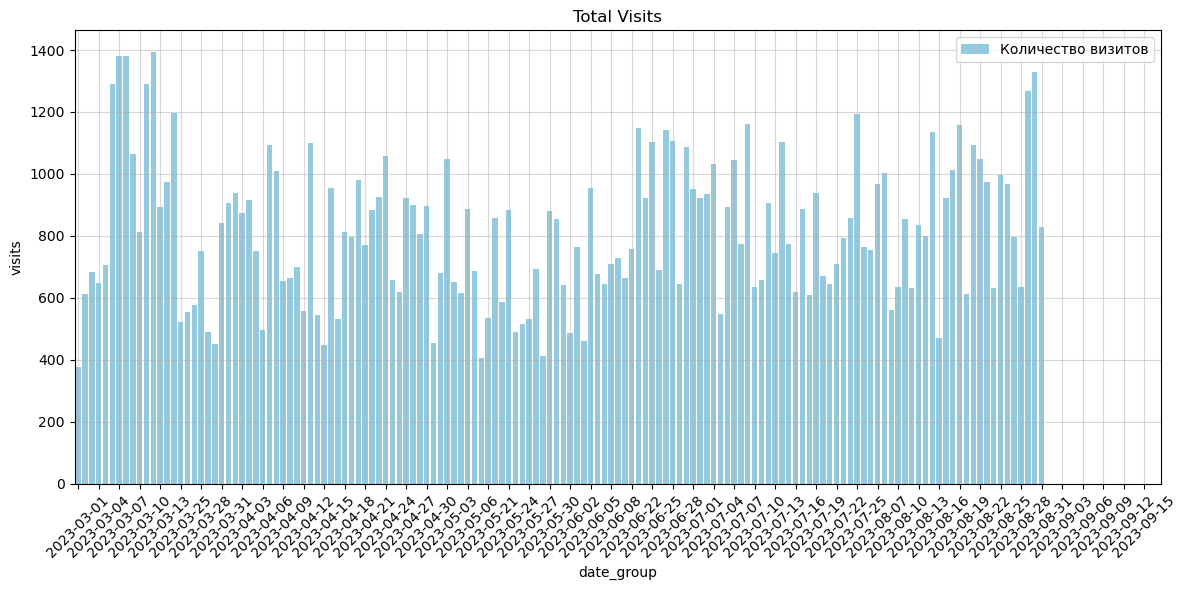

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(data=ads, x='date_group', y='visits', color='skyblue', label='Количество визитов')

plt.xlabel('date_group')
plt.ylabel('visits')
plt.title('Total Visits')
plt.xticks(ads['date_group'][::3], rotation=45)
plt.grid(alpha=0.5)

plt.legend()
plt.tight_layout()

plt.savefig('./charts/total_visits.png')

#### Итоговые визиты с разбивкой по платформам: web, android, ios

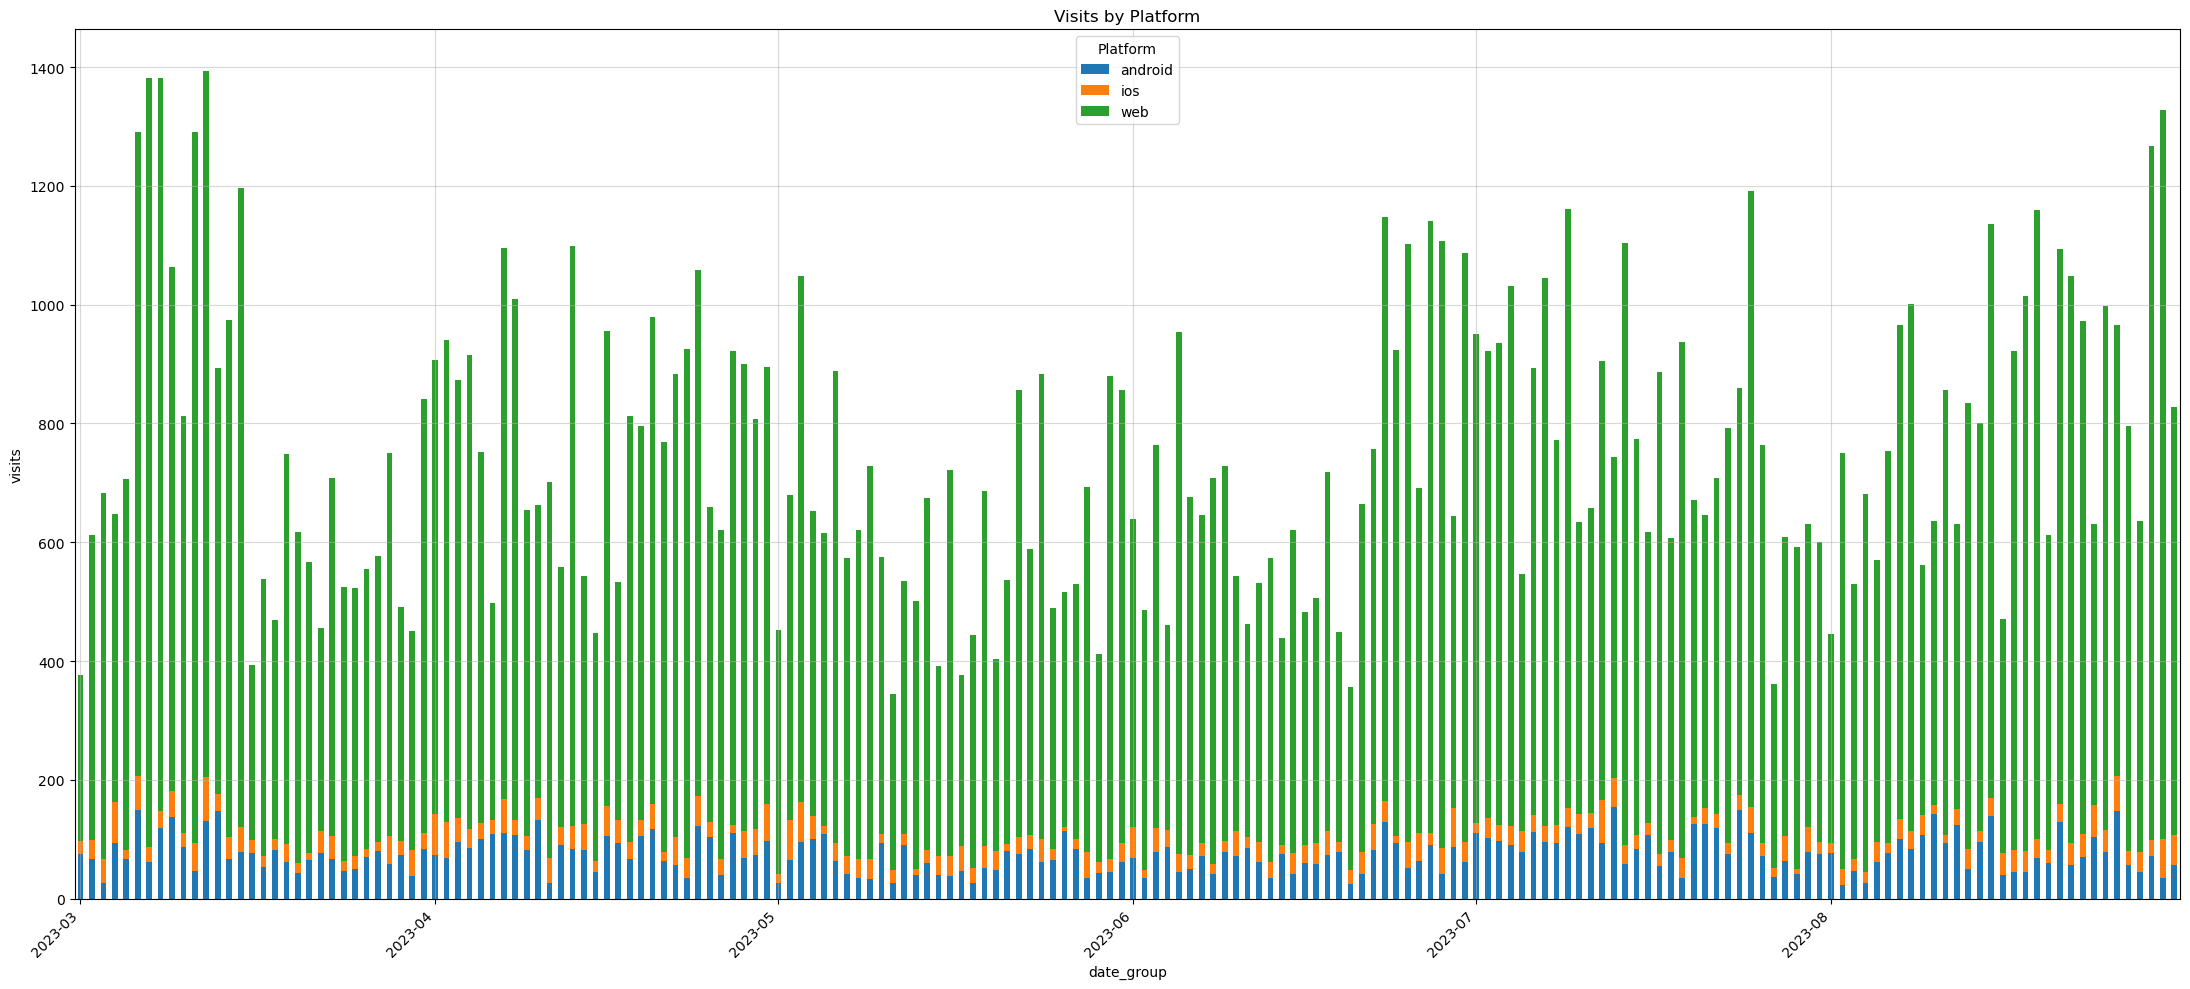

In [19]:
stacked_data = conversion.pivot_table(index='date_group', columns='platform', values='visits', aggfunc='sum', fill_value=0)

plt.figure(figsize=(22, 10))
stacked_data.plot(kind='bar', stacked=True, ax=plt.gca())

# Настройки графика
plt.xlabel('date_group')
plt.ylabel('visits')
plt.title('Visits by Platform')

# Преобразуем индекс в pd.DatetimeIndex и получаем только первые дни месяца
stacked_data.index = pd.to_datetime(stacked_data.index)  # Убедитесь, что индекс в формате datetime
monthly_ticks = stacked_data.index[stacked_data.index.day == 1]  # Получаем только первые дни месяца
monthly_tick_positions = [stacked_data.index.get_loc(date) for date in monthly_ticks]  # Позиции на оси X для этих дат

# Настройка подписей на оси X
plt.xticks(monthly_tick_positions, labels=monthly_ticks.strftime('%Y-%m'), rotation=45, ha='right')

# Сетка и легенда
plt.grid(alpha=0.5)
plt.legend(title='Platform')

# Обновление положения графика
plt.tight_layout()

# Сохранение и отображение графика
plt.savefig('./charts/visits_by_platform.png')

#### Итоговые регистрации

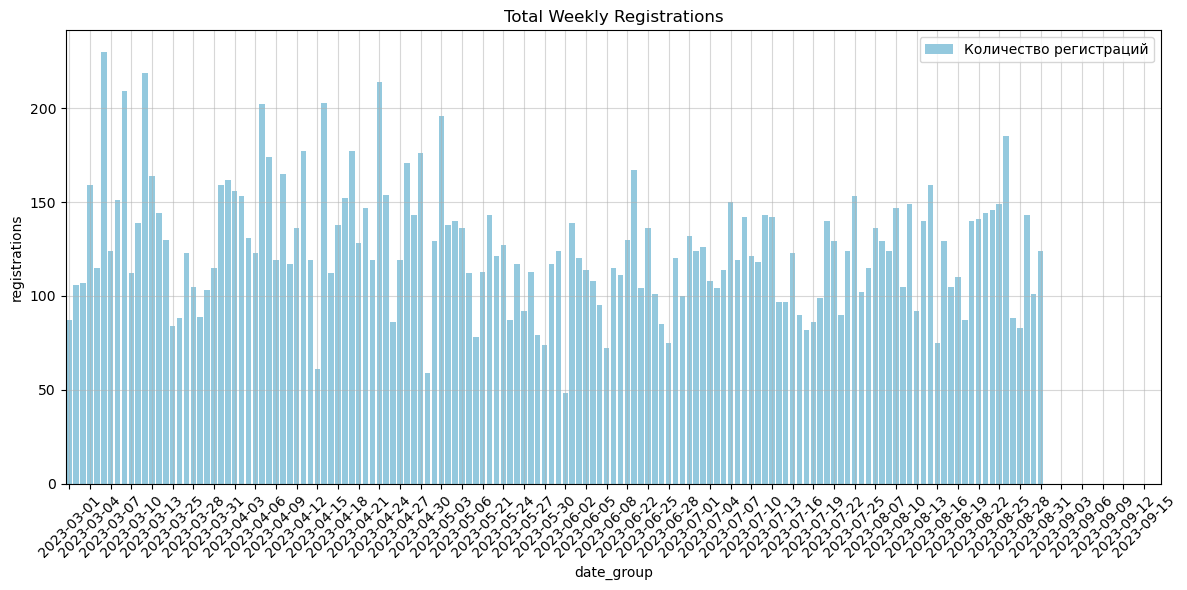

In [21]:
plt.figure(figsize=(12, 6))
sns.barplot(data=ads, x='date_group', y='registrations', color='skyblue', label='Количество регистраций')

plt.xlabel('date_group')
plt.ylabel('registrations')
plt.title('Total Weekly Registrations')
plt.xticks(ads['date_group'][::3], rotation=45)
plt.grid(alpha=0.5)

plt.legend()
plt.tight_layout()

plt.savefig('./charts/total_weekly_registrations.png')

#### Итоговые регистрации с разбивкой по платформе: web, android, ios

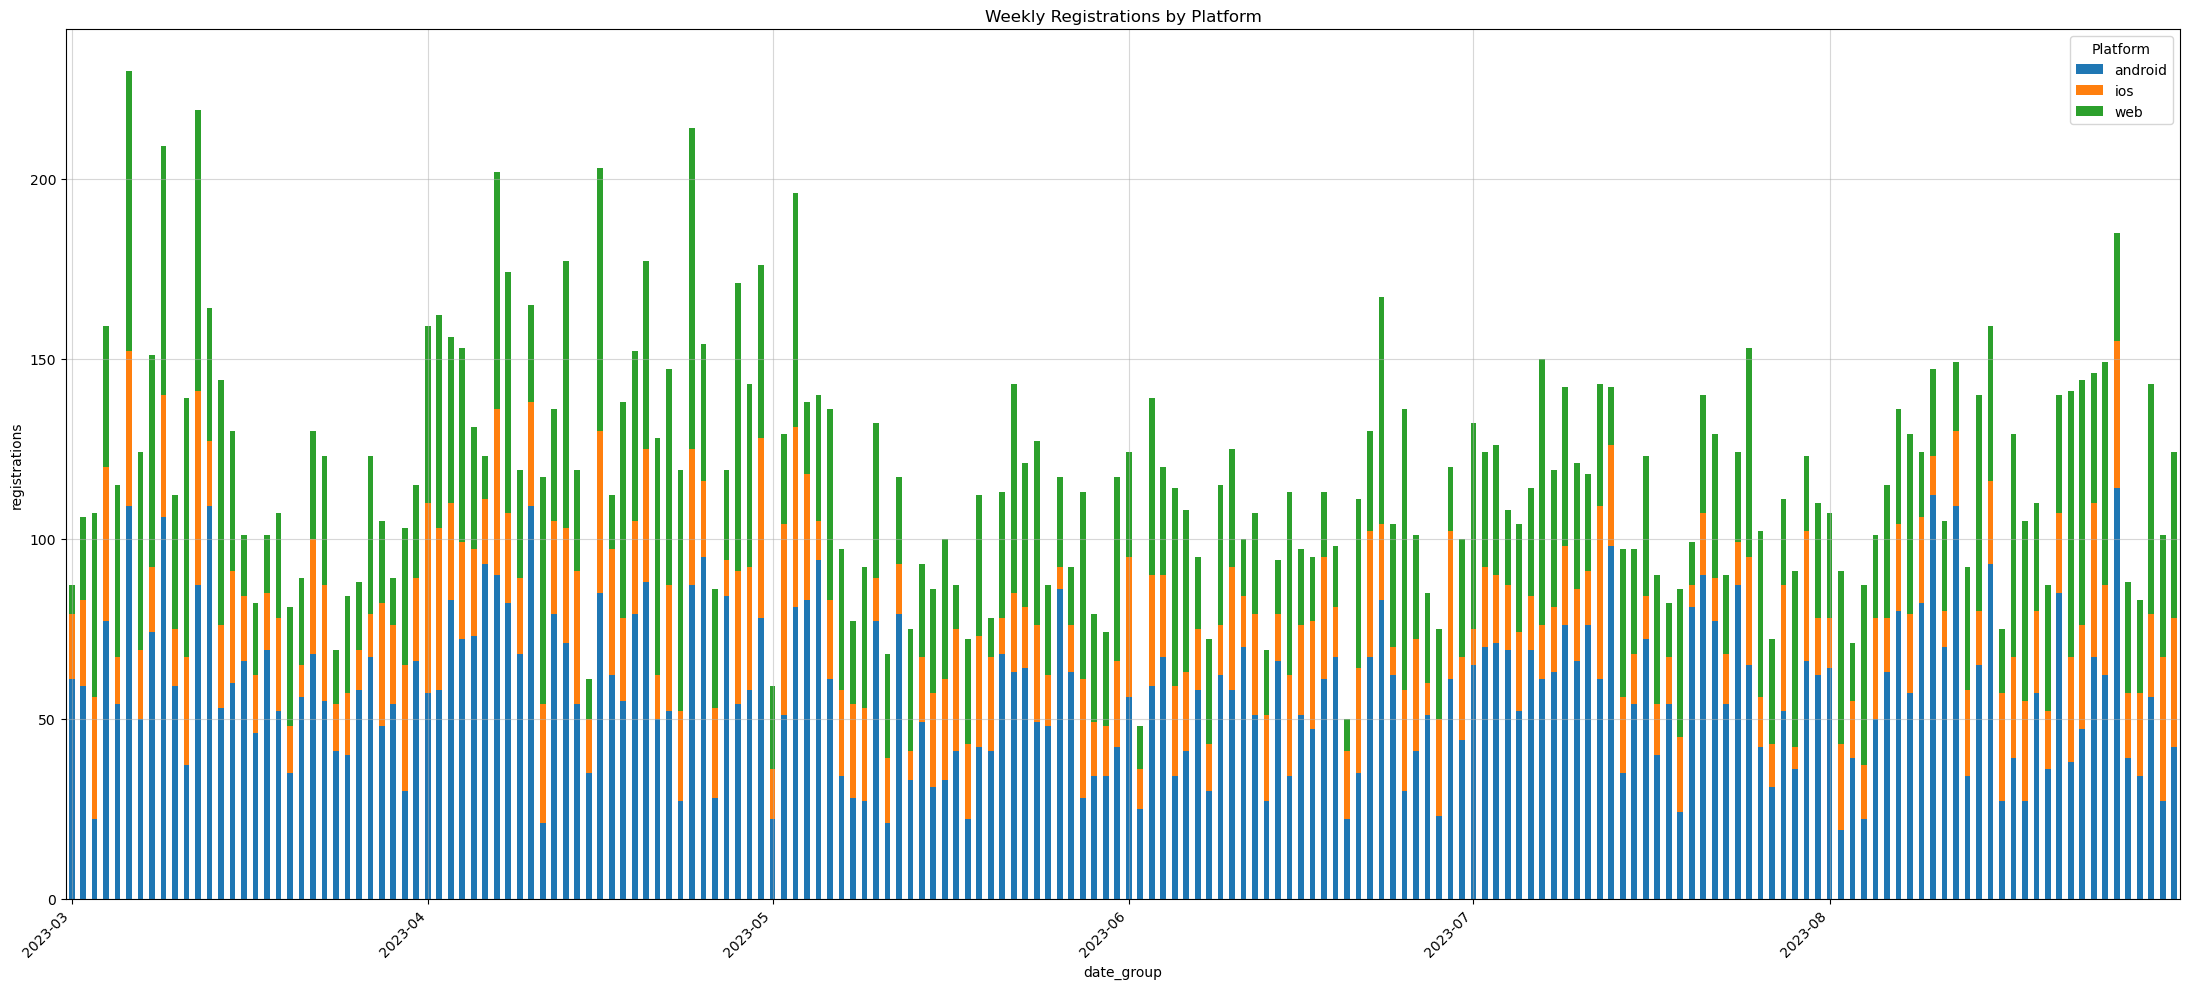

In [23]:
stacked_data_1 = conversion.pivot_table(index='date_group', columns='platform', values='registrations', aggfunc='sum', fill_value=0)

plt.figure(figsize=(22, 10))
stacked_data_1.plot(kind='bar', stacked=True, ax=plt.gca())

# Настройки графика
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.title('Weekly Registrations by Platform')

# Преобразуем индекс в pd.DatetimeIndex и получаем только первые дни месяца
stacked_data_1.index = pd.to_datetime(stacked_data_1.index)  # Убедитесь, что индекс в формате datetime
monthly_ticks = stacked_data_1.index[stacked_data_1.index.day == 1]  # Получаем только первые дни месяца
monthly_tick_positions = [stacked_data_1.index.get_loc(date) for date in monthly_ticks]  # Позиции на оси X для этих дат

# Настройка подписей на оси X
plt.xticks(monthly_tick_positions, labels=monthly_ticks.strftime('%Y-%m'), rotation=45, ha='right')

# Сетка и легенда
plt.grid(alpha=0.5)
plt.legend(title='Platform')

# Обновление положения графика
plt.tight_layout()

# Сохранение и отображение графика
plt.savefig('./charts/weekly_registrations_by_platform.png')

#### Конверсия по каждой платформе